In [21]:
from pylab import *
from numpy.linalg import norm
from numpy import random
from scipy import interpolate,integrate
from ipywidgets import IntProgress
from IPython.display import display,clear_output
from scipy.integrate import simps
from matplotlib import rc

import os.path as path
import sys
import pandas as pd

rcParams['figure.figsize'] = [8, 8]
rcParams['axes.labelsize'] = 20
rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage[russian]{babel}',
                         r'\usepackage{amsmath}',
                        r'\usepackage{amssymb}',
                        r'\usepackage{mathrsfs}'])
rc('font', family='serif')

def find_decision(omega):
    P = 9.8*1000.0/0.074;
    Q = -1000.0*omega**2/0.074;
    x1= -Q/2.0 + sqrt( (Q/2)**2 + (P/3)**3 )
    x2= -Q/2.0 - sqrt( (Q/2)**2 + (P/3)**3 )
    k=x1**(1/3)-(-x2)**(1/3)
    return k

def det(k): 
#        Функция возвращает Якобиан при переходе от частоты к 
#    волновым числам по полному дисперсионному уравнению

    det=(9.8+3*k**2*0.074/1000)/(2*sqrt(9.8*k+k**3*0.074/1000) )
    return det

def k_max(omega_max):
    # k_max -- координата пика спектра
    k_max=omega_max**2/g
    return k_max

def omega_k(k): 
    #    Пересчет волнового числа в частоту по полному дисперсионному
    # уравнению   
    omega_k=(g*k+0.074*k**3/1000)**(1/2) 
    return omega_k  

def Full_spectrum(k,x=20170, long_calculate=True):
    #    Спектр JONSWAP. 
    #    По совместительству, граница моделируюмого спектра #0
    # 0< omega < 1.2*omega_max 
    def JONSWAP(k):
        if k<=k_m:
            sigma=0.07
        else:
            sigma=0.09
        Sw=(
            Alpha(x)/2*k**(-3)*exp(-1.25*(k_m/k)**2 )*
            Gamma(x)**(exp(- ( sqrt(k/k_m)-1)**2 / (2*sigma**2) ))
           )
        return Sw
    # Безразмерный коэффициент Gamma
    def Gamma(x):
        if x>=20170:
            return 1
        gamma=(
               +5.253660929
               +0.000107622*x
               -0.03778776*sqrt(x)
               -162.9834653/sqrt(x)
               +253251.456472*x**(-3/2)
              )
        return gamma
    # Безразмерный коэффициент Alpha
    def Alpha(x):
        if x>=20170:
            return 0.0081
        alpha=array([],dtype='float64')
        alpha=[( 
               +0.0311937
               -0.00232774*log(x)
               -8367.8678786/x**2
               +4.5114599e+300*exp(-x)*1e+300*1e+17
    #            +4.5114599e+17*exp(-x)
              )]
        return alpha[0]
    #Вычисление безразмерной частоты Omega по безразмерному разгону x
    def Omega(x): 
        if x>=20170:
            return 0.835
        omega_tilde=(0.61826357843576103 
                     + 3.52883010586243843e-06*x
                     - 0.00197508032233982112*sqrt(x)
                     + 62.5540113059129759/sqrt(x)
                     - 290.214120684236224/x
        )
        return omega_tilde

    def spectrum1(k):
        # Граница моделируюмого спектра #1
        # 1.2*omega_max < omega < a_m omega_m
        omega0=omega_k(limit_k[0])
        beta0= JONSWAP(limit_k[0])*omega0**4/det(limit_k[0])
        omega0=omega_k(k)

        return beta0/omega0**4*det(k)

    def spectrum2(k):
        # Граница моделируюмого спектра #2
        # a_m(U_10) omega_m < omega < omega_gk simeq 60 рад/с
        omega0=omega_k(limit_k[1])
        beta0= spectrum1(limit_k[1])*omega0**5/det(limit_k[1])

        omega0=omega_k(k)

        return beta0/omega0**5*det(k)

    def spectrum3(k):
        # Граница моделируюмого спектра #3
        #  omega_gk < omega < omega_h simeq 290 рад/с
        omega0=omega_k(limit_k[2])
        beta0= spectrum2(limit_k[2])*omega0**2.7/det(limit_k[2])

        omega0=omega_k(k)

        return beta0/omega0**2.7*det(k)

    def spectrum4(k):
        # Граница моделируюмого спектра #4
        #  omega_h < omega 
        omega0=omega_k(limit_k[3])
        beta0= spectrum3(limit_k[3])*omega0**5/det(limit_k[3])

        omega0=omega_k(k)

        return beta0*det(k)/omega0**5
        
    gamma,alpha,omega_m=Gamma(x),Alpha(x),Omega(x)
    
    try:
        full_spectrum=zeros(len(k))
    except:
        full_spectrum=[0]
        k=[k]
    if long_calculate==False:
        k=logspace(log10(k[0]),log10(k[-1]),1000)
        
    omega=omega_m*g/U10
    global k_m
    k_m=k_max(omega)
    
    # См. функции spectrum_{1-4}(k)< 
    # limit_{1-4} -- это соответствующие границы
    limit_1= 1.2
    limit_2=(
             +0.371347584096022408 
             + 0.290241610467870486*U10
             + 0.290178032985796564/U10
            )
    limit_3= 270.0
    limit_4= 1020.0

    limit_k=np.zeros(4)
    limit_k[0]=find_decision(limit_1*omega)
    limit_k[1]=find_decision(limit_2*omega)
    limit_k[2]=limit_3
    limit_k[3]=limit_4
    
    # Цикл ниже сшивает спектр на границах.
    for i in range(len(k)):
        if k[i] <= limit_k[0]:
            full_spectrum[i] =  JONSWAP(k[i])
        elif k[i] <= limit_k[1]:
            full_spectrum[i] = spectrum1(k[i])
        elif k[i] <= limit_k[2]:
            full_spectrum[i] = spectrum2(k[i])
        elif k[i] <= limit_k[3]:
            full_spectrum[i] = spectrum3(k[i])
        else:
            full_spectrum[i] = spectrum4(k[i])  
    return full_spectrum

def B(k):
    def b(k):
        b=(
            -0.28+0.65*exp(-0.75*log(k/k_m))
            +0.01*exp(-0.2+0.7*log10(k/k_m))  
          )          
        return b
    B=10**b(k)
    return B

def Normalization(B):
    #Нормировочный коэффициент для функции углового распределения
    Normalization=B/arctan(sinh(2*pi*B))
    return Normalization

def Phi(k,phi):
    # Функция углового распределения
    # Костыль в виде try-except мне был нужен, 
    # чтобы можно было считать числа, а не массивы. Зачем? Уже не помню.
    try:
        Phi=zeros((len(k),len(phi)))
        for i in range(len(k)):
            B0=B(k[i])
            A0=Normalization(B0)
            Phi[i]=A0/cosh(2*B0*phi)
    except:
        B0=B(k)
        A0=Normalization(B0)
        Phi=A0/cosh(2*B0*phi)
    return Phi

def angle(k,phi):
    angle=sqrt( 2*pi/100 * Phi(k,phi) )
    return angle

def amplitude(k):
    # k-- выбранный диапазон волновых чисел
    # N-- количество моделируемых гармоник
    N = len(k)
    S = full_spectrum(k)
    dk = zeros(N)
    dS = zeros(N)
    if len(k) == 1:
        dk[0] = k[0]
        dS[0] = S[0]
    for i in range(1,N):
        dk[i] = (k[i] - k[i-1])
        dS[i] = S[i]
    amplitude = sqrt(2 * dk * dS)
    return amplitude


def interspace(k, N):
    # Функция разбивает заданный k-интервал на N участков, в каждои из которых
    # интеграл по спектру принимает одно и тоже значение. 
    # Для метода <<отбеливания спектра>>.
    y = lambda k: full_spectrum(k)*k**power
    sigma = trapz(y(k),k)
    b0 = sigma/(N)
    k_new = k[0]
    a = k[-1]
    k = zeros(N+1)
    k[0] = k_new
    err = zeros(N)
    file ='interspace_'+identification+'.tsv'
    if path.isfile(file) == True:
        data = pd.read_csv(file,sep='\t')
        nodes = array(data['k'])
        return k,b0,err
    
    epsabs = 1.49e-12
    epsrel = 1.49e-12
    f = IntProgress(min=0,max=N-1)
    display(f,'Разбиваю на интервалы')
    for i in range(N-1):
        integral = 0
        n = 1
        m = 1
        while integral < b0:
            k_new*= 1 + 10**(-m)
            if k_new > a:
                k_new = a
                break
            integral,error = integrate.quad(y, k[i], k_new,
            limit = 50,epsabs = epsabs, epsrel=epsrel)
            if integral> b0 and abs(integral-b0) > epsabs:
                k_new*= 1 - 10**(-m)
                m+= 1
                integral, error = integrate.quad(y, k[i], k_new,
                limit=50, epsabs=epsabs, epsrel=epsrel)
            n+= 1
        f.value+= 1
        k[i+1] = k_new
    k = k[0:N+1]
    k[-1] = a
    # Возвращает k размерности N+1, т.о. имеем как раз N интервалов.
    # b0 -- значение интеграла по каждому интервалу
    # err -- ошибка вычисения интегралов
    clear_output()
    
    file = 'interspace_'+identification+'.tsv'
    df = pd.DataFrame({'k': k})
    df.to_csv(file,sep = '\t')
    return k,b0,err

def space_select(i):
    space = ['linear','log','white spectrum']
    if space[i] == 'log':
        k = logspace(log10(KT[0]), log10(KT[-1]),len(node))
    elif space[i] == 'linear':
        k = linspace(KT[0], KT[-1], 10**2*len(node))
    elif space[i] == 'white spectrum':
        k = node
    return k


def correlation_angles(k,rho):
    integral=zeros(len(rho))
    y=lambda k,rho: k**2*full_spectrum(k)*cos(k*rho)
    for i in range(len(rho)):
        integral[i]=trapz(y(k,rho[i]),x=k)
    integral=interpolate.interp1d(rho,integral)
    return integral
    
def correlation_angles_sum(k,rho):
    f=0
    A=amplitude(k)
    f=zeros(len(rho))
    for j in range(len(rho)):
            f[j]=sum( k**2*A**2/2*cos(k*rho[j]) )
    
    return f

def correlation_height(k,rho):
    
    S=full_spectrum(k)
    integral=zeros(len(rho))
    for i in range(len(rho)):
        integral[i]=trapz(S*cos(k*rho[i]),k)
    integral=interpolate.interp1d(rho,integral)
    return integral

def correlation_height_sum(k,rho):
    f=0
    A=amplitude(k)
    f=zeros(len(rho))
    for j in range(len(rho)):
            f[j]=sum( A**2/2*cos(k*rho[j]) )
    return f


def nodes(ki,b0):
    file='node_'+identification+'.tsv'
    if path.isfile(file)==True:
        data=pd.read_csv(file,sep='\t')
        nodes=array(data['k'])
        return nodes
    
    elif path.isfile(file)==False:
        # Функции interspace и nodes используются последовательно. 
        # Первая возвращает интервалы,
        # а вторая вычисляет в возвращенных интервалах координаты узлов
        f=IntProgress(min=0,max=len(ki))
        display(f,'Считаю узлы в интервалах')
        y=lambda k: k**(power+2)*full_spectrum(k)
        nodes=zeros(len(ki))
        epsabs=1.49e-12
        epsrel=1.49e-12
        A=sqrt(2*b0)
        for i in range(1,len(ki)):
            integral,error=integrate.quad(y,ki[i-1],ki[i],
            limit=50,epsabs=epsabs, epsrel=epsrel)
            B=(sqrt(integral/A**2))
            nodes[i-1]=B
            f.value+=1
            
        clear_output()
        file='node_'+identification+'.tsv'
        df=pd.DataFrame({'k': nodes[:-1]})
        df.to_csv(file,sep='\t')
        return nodes[:-1]

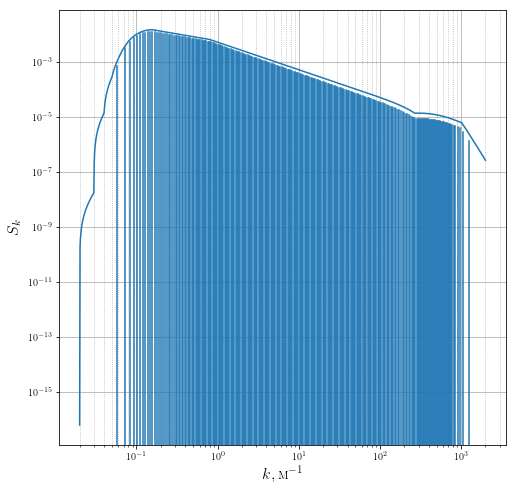

In [11]:
identification='slopes'
# identification='height'
if identification=='slopes':
    power=2
elif identification=='height':
    power=0
    
global g
g=9.81
KT=array([0.02,2000])
U10=8

# Не забыть бы для приличия снести эти строчки к основную программу.
# Интерполируем наш спектр. 
# Позволяет не думать над различными размерами массивов при счете
k=arange(KT[0]*10**(-10),KT[-1]+100,0.01)
full_spectrum=interpolate.interp1d(k,Full_spectrum(k))
k=logspace(log10(KT[0]),log10(KT[-1]),10**3)
ki,b0,err=interspace(k,256)
node=nodes(ki,b0)
y=full_spectrum(k)*k**power
loglog(k,y)
for i in node:
    axvline(x=i, 
            ymax=0.95*(
                log10(full_spectrum(i)*i**power/(min(y)))/(log10(max(y)/min(y)))
                 ))
    
xlabel(r'$k, {\text{м}}^{-1}$',fontsize=16)
ylabel(r'$S_k$',fontsize=16)
grid(which='major', linestyle='-')
grid(which='minor', linestyle=':')
minorticks_on()
show()

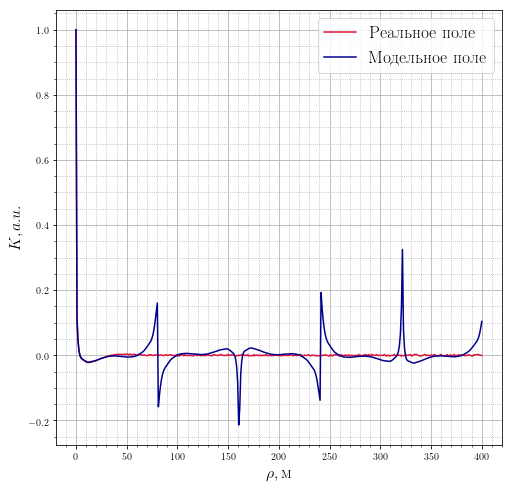

In [22]:
identity=0
rho=linspace(0,400,400)
y=zeros(len(rho))
k=logspace(log10(KT[0]),log10(KT[-1]),10**5)
y1=correlation_angles(k,rho)
k=space_select(identity)
y=correlation_angles_sum(k,rho)
y1=y1(rho)
real=y1/max(y1)
modeling=y/max(y)
plot(rho,real,label='Реальное поле',color='crimson')
plot(rho,modeling,label='Модельное поле',color='darkblue')
legend(fontsize=16)
xlabel(r'${\rho},\text{м}$',fontsize=16)
ylabel(r'$K, a.u.$',fontsize=16)
grid(which='major', linestyle='-')
grid(which='minor', linestyle=':')
minorticks_on()
savefig(path.abspath('..'+'\\water\\TeX\\fig\\correlation_angles5_'
                     +identification+str(identity)+'.pdf'),
       bbox_inches='tight')
show()

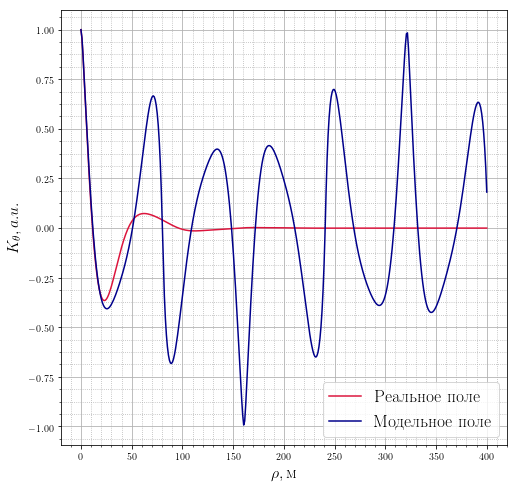

In [23]:
identity=0
rho=linspace(0,400,400)
y=zeros(len(rho))
k=logspace(log10(KT[0]),log10(KT[-1]),10**5)
y1=correlation_height(k,rho)
k=space_select(identity)
y=correlation_height_sum(k,rho)
y1=y1(rho)
real=y1/max(y1)
modeling=y/max(y)
plot(rho,real,label='Реальное поле',color='crimson')
plot(rho,modeling,label='Модельное поле',color='darkblue')
legend(fontsize=16)
xlabel(r'${\rho},\text{м}$',fontsize=16)
ylabel(r'$K_{\theta}, a.u.$',fontsize=16)
grid(which='major', linestyle='-')
grid(which='minor', linestyle=':')
minorticks_on()

savefig(path.abspath('..'+'\\water\\TeX\\fig\\correlation_height5_'
                     +identification+str(identity)+'.pdf'),
       bbox_inches='tight')
show()

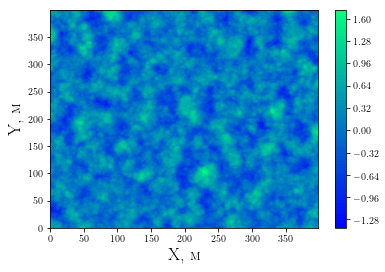

In [5]:
def model(k,phi):
    N=len(k)
    rho=linspace(0,400,400)
    A=amplitude(k)
    F=angle(k,phi)
    psi=array([
    [ random.uniform(0,2*pi) for j in range(100)] 
      for i in range(N)              ]) 
    
    def water(r,phi,t=0):
        model=0
        for n in range(N):
            for m in range(100):
                model+=A[n]*cos(
                    k[n]*(r[0]*cos(phi[m])+r[1]*sin(phi[m]))+psi[n][m]
                )*F[n][m]
        return model
    return water

k=node
phi=linspace(-pi,pi,100)

sigma=model(k,phi)


x=linspace(0,400,400)
y=linspace(0,400,400)
x, y = np.meshgrid(x, y)

file='model.tsv'
if path.isfile(file)==True:
    data=pd.read_csv(file,sep='\t',header=0,names=range(1,400))
    z=array(data)
elif path.isfile(file)==False:
    z=sigma([x,y],phi)
    df=pd.DataFrame(data=z)
    df.to_csv(file,sep='\t')

contourf(z,100,cmap=cm.winter)
colorbar()
ylabel(r'Y, \text{м}',fontsize=16)
xlabel(r'X, \text{м}',fontsize=16)
savefig(path.abspath('..'+'\\water\\TeX\\fig\\'+'water'+str(U10)+'.pdf'),
        pdi=10**4,bbox_inches='tight')
show()

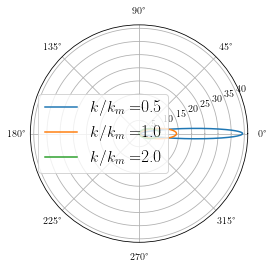

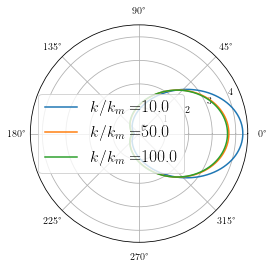

In [6]:
x=linspace(-pi,pi,10000)
temp=[k_m/2,k_m,2*k_m]
for t in temp:
    y=Phi(t,x)
    polar(x,y/k_m,label=r'$k/k_m=$' + str(round(t/k_m,3)))
legend(loc='center left',fontsize=16)
savefig(path.abspath('..'+'\\water\\TeX\\fig\\full_angles1.pdf'),
       bbox_inches='tight')
show()
temp=[10*k_m,50*k_m,100*k_m]
for t in temp:
    y=Phi(t,x)
    polar(x,y/k_m,label=r'$k/k_m=$' + str(round(t/k_m,3)))
legend(loc='center left',fontsize=16)
savefig(path.abspath('..'+'\\water\\TeX\\fig\\full_angles2.pdf'),
       bbox_inches='tight')
show()

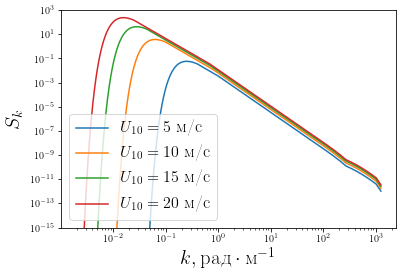

In [7]:
x=20170

U10=5
k=logspace(log10(KT[0]),log10(k[-1]),1000)
C=Full_spectrum(k,x)
loglog(k,C,label=r'$U_{10}=5 \text{ м/с}$')

U10=10
k=logspace(log10(KT[0]/10),log10(k[-1]),1000)
C=Full_spectrum(k,x)
loglog(k,C,label=r'$U_{10}=10 \text{ м/с}$')

U10=15
k=logspace(log10(KT[0]/10),log10(k[-1]),1000)
C=Full_spectrum(k,x)
loglog(k,C,label=r'$U_{10}=15 \text{ м/с}$')

U10=20
k=logspace(log10(KT[0]/10),log10(k[-1]),1000)
C=Full_spectrum(k,x)
loglog(k,C,label=r'$U_{10}=20 \text{ м/с}$')
legend(fontsize=16)

xlabel(r'$k, \text{рад}\cdot\text{м}^{-1}$')
ylabel(r'$S_{k}$')
ylim((10**(-15),1000))
savefig(path.abspath('..'+'\\water\\TeX\\fig\\full_spectrum1.pdf'),
       bbox_inches='tight')
show()

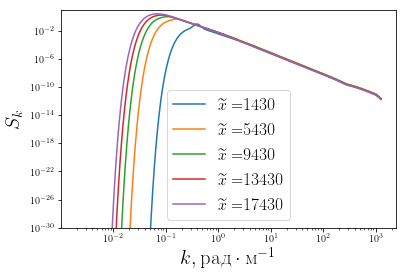

In [8]:
xx=arange(1430,20000,4000)
U10=10
for n in xx:
    x=n
    k=logspace(log10(k[0]),log10(k[-1]),1000)
    C=Full_spectrum(k,n)
    loglog(k,C,label=r'$\widetilde{x}=$'+'{0}'.format(x))

ylim([10**-30,10])
xlabel(r'$k, \text{рад}\cdot\text{м}^{-1}$')
ylabel(r'$S_{k}$')
legend(fontsize=16)
savefig(path.abspath('..'+'\\water\\TeX\\fig\\full_spectrum2.pdf'),
       bbox_inches='tight')
show()

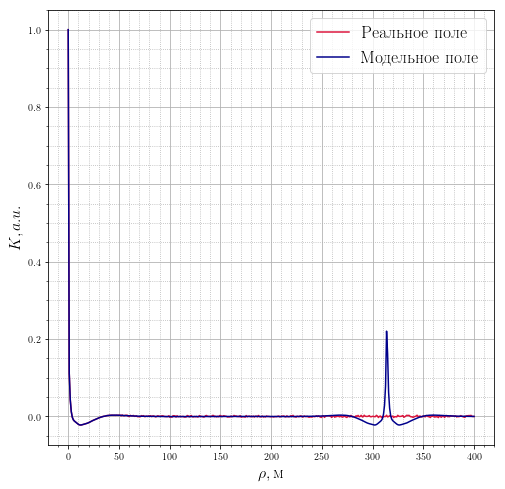

In [31]:
identity=2
rho=linspace(0,400,400)
y=zeros(len(rho))
k=logspace(log10(KT[0]),log10(KT[-1]),10**5)
y1=correlation_angles(k,rho)
k=linspace(KT[0],KT[-1],10**5)
y=correlation_angles_sum(k,rho)
y1=y1(rho)
real=y1/max(y1)
modeling=y/max(y)
plot(rho,real,label='Реальное поле',color='crimson')
plot(rho,modeling,label='Модельное поле',color='darkblue')
legend(fontsize=16)
xlabel(r'${\rho},\text{м}$',fontsize=16)
ylabel(r'$K, a.u.$',fontsize=16)
grid(which='major', linestyle='-')
grid(which='minor', linestyle=':')
minorticks_on()
savefig(path.abspath('..'+'\\water\\TeX\\fig\\correlation_angles5_'
                     +identification+str(identity)+'.pdf'),
       bbox_inches='tight')
show()